### FOR 30 EPOCHS

In [10]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve



data_dir = '/content/drive/MyDrive/ACV/mvtec_anomaly_detection'


class MyDataset(Dataset):
    def __init__(self, base_dir, data_type, transform=None):
        self.base_dir = base_dir
        self.data_type = data_type
        self.transform = transform
        self.image_files = []
        self.targets = []
        self.normal_count = 0
        self.anomaly_count = 0

        for category in os.listdir(base_dir):
            category_path = os.path.join(base_dir, category)
            if os.path.isdir(category_path):
                type_path = os.path.join(category_path, data_type)
                if os.path.isdir(type_path):
                    for defect_class in os.listdir(type_path):
                        defect_class_path = os.path.join(type_path, defect_class)
                        if os.path.isdir(defect_class_path):
                            for img_file in os.listdir(defect_class_path):
                                img_file_path = os.path.join(defect_class_path, img_file)
                                if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
                                    self.image_files.append(img_file_path)
                                    if data_type == 'train' or defect_class.lower() == 'good':
                                        self.targets.append(0)  # Normal images
                                        self.normal_count += 1
                                    else:
                                        self.targets.append(1)  # Anomalous images
                                        self.anomaly_count += 1

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = self.image_files[index]
        img = Image.open(img_path).convert('RGB')
        label = self.targets[index]
        if self.transform:
            img = self.transform(img)
        return img, label

img_transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])


train_data = MyDataset(data_dir, 'train', transform=img_transform)
test_data = MyDataset(data_dir, 'test', transform=img_transform)

train_loader = DataLoader(train_data, shuffle=True, batch_size=64, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=64, drop_last=True)

print(f"Training images: {len(train_data)}")
print(f"  Normal in training set: {train_data.normal_count}")
print(f"Testing images: {len(test_data)}")
print(f"  Normal in test set: {test_data.normal_count}")
print(f"  Anomalous in test set: {test_data.anomaly_count}")

Training images: 3629
  Normal in training set: 3629
Testing images: 1725
  Normal in test set: 467
  Anomalous in test set: 1258


In [11]:

learning_rate = 1e-4
training_steps = 30  
batch_sz = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {'GPU' if torch.cuda.is_available() else 'CPU'}.")

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = AutoEncoder().to(device)
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
print(f'> Model parameters: {sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)}')

Training on GPU.
> Model parameters: 38723


  0%|          | 0/30 [00:00<?, ?it/s]

Step: 0   Loss: 0.661


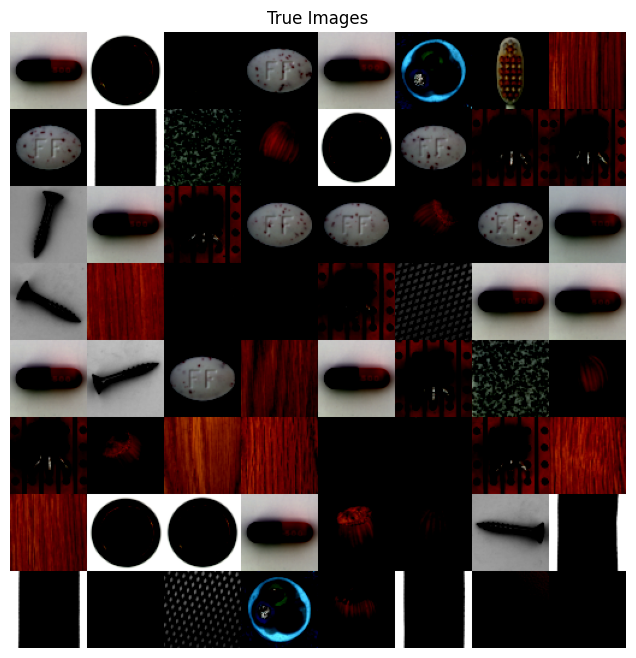

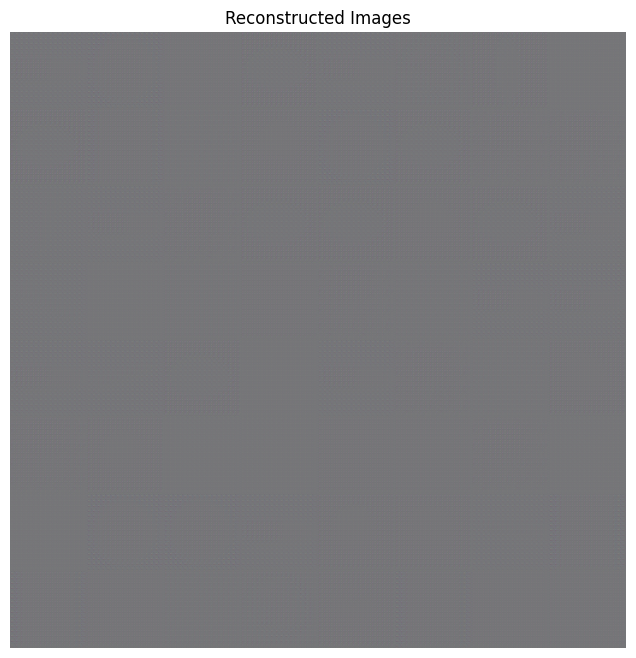

100%|██████████| 30/30 [12:55<00:00, 25.85s/it]


In [7]:

train_losses = []
for step in tqdm(range(training_steps)):
    x, _ = next(iter(train_loader))
    x = x.to(device)


    outputs = autoencoder(x)
    loss = nn.MSELoss()(outputs, x)

    autoencoder_optimizer.zero_grad()
    loss.backward()
    autoencoder_optimizer.step()

    train_losses.append(loss.item())

    if step % 100 == 0:
        print(f"Step: {step}   Loss: {loss.item():.3f}")

        reconstructions = torchvision.utils.make_grid(torch.clamp(outputs, 0, 1).detach(), padding=0, nrow=8)
        true_images = torchvision.utils.make_grid(torch.clamp(x, 0, 1).detach(), padding=0, nrow=8)

        plt.figure(figsize=(8, 8))
        plt.title('True Images')
        plt.imshow(np.transpose(true_images.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')

        plt.figure(figsize=(8, 8))
        plt.title('Reconstructed Images')
        plt.imshow(np.transpose(reconstructions.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')

        plt.show()

In [8]:

def dynamic_threshold(loss_vals):
    mean_loss = np.mean(loss_vals)
    std_loss = np.std(loss_vals)
    return mean_loss + 2 * std_loss 

initial_threshold = dynamic_threshold(train_losses)
print(f"Initial anomaly detection threshold: {initial_threshold}")

def reconstruction_errors(autoencoder, data_loader):
    autoencoder.eval()
    errors = []
    true_labels = []
    with torch.no_grad():
        for imgs, labels in tqdm(data_loader, desc="Evaluating"):
            imgs = imgs.to(device)
            outputs = autoencoder(imgs)
            loss = torch.mean((outputs - imgs) ** 2, dim=[1, 2, 3])
            errors.extend(loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(errors), np.array(true_labels)

recon_errors, true_lbls = reconstruction_errors(autoencoder, test_loader)


assert recon_errors.shape == true_lbls.shape, "Shape mismatch between errors and true labels."


anomalies_detected = recon_errors > initial_threshold
print(f"Detected anomalies: {np.sum(anomalies_detected)}")

true_labels_list = []
pred_labels_list = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Anomaly Detection"):
        imgs = imgs.to(device)
        outputs = autoencoder(imgs)
        recon_error = torch.mean((outputs - imgs) ** 2, dim=[1, 2, 3]).cpu().numpy()
        true_labels_list.extend(labels.cpu().numpy())
        pred_labels_list.extend([1 if e > initial_threshold else 0 for e in recon_error])

print(f"Anomalies detected in the test set: {np.sum(anomalies_detected)}")



Initial anomaly detection threshold: 0.7416379755911178


Evaluating: 100%|██████████| 26/26 [14:52<00:00, 34.33s/it]


Detected anomalies: 712


Anomaly Detection: 100%|██████████| 26/26 [01:05<00:00,  2.53s/it]

Anomalies detected in the test set: 712


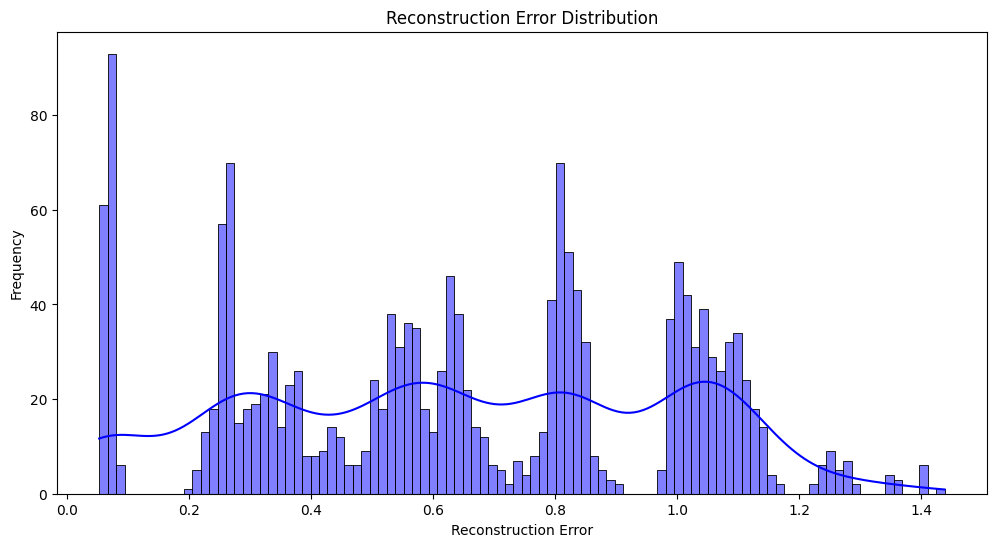

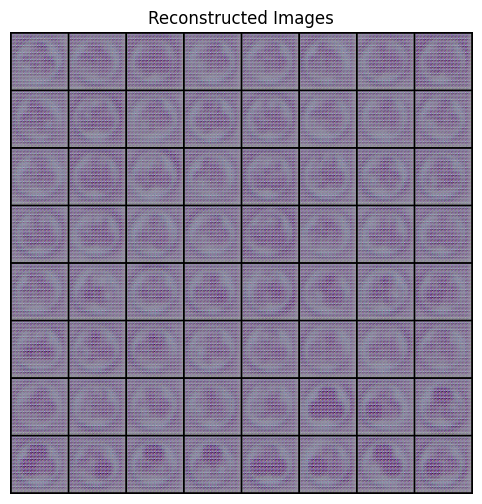

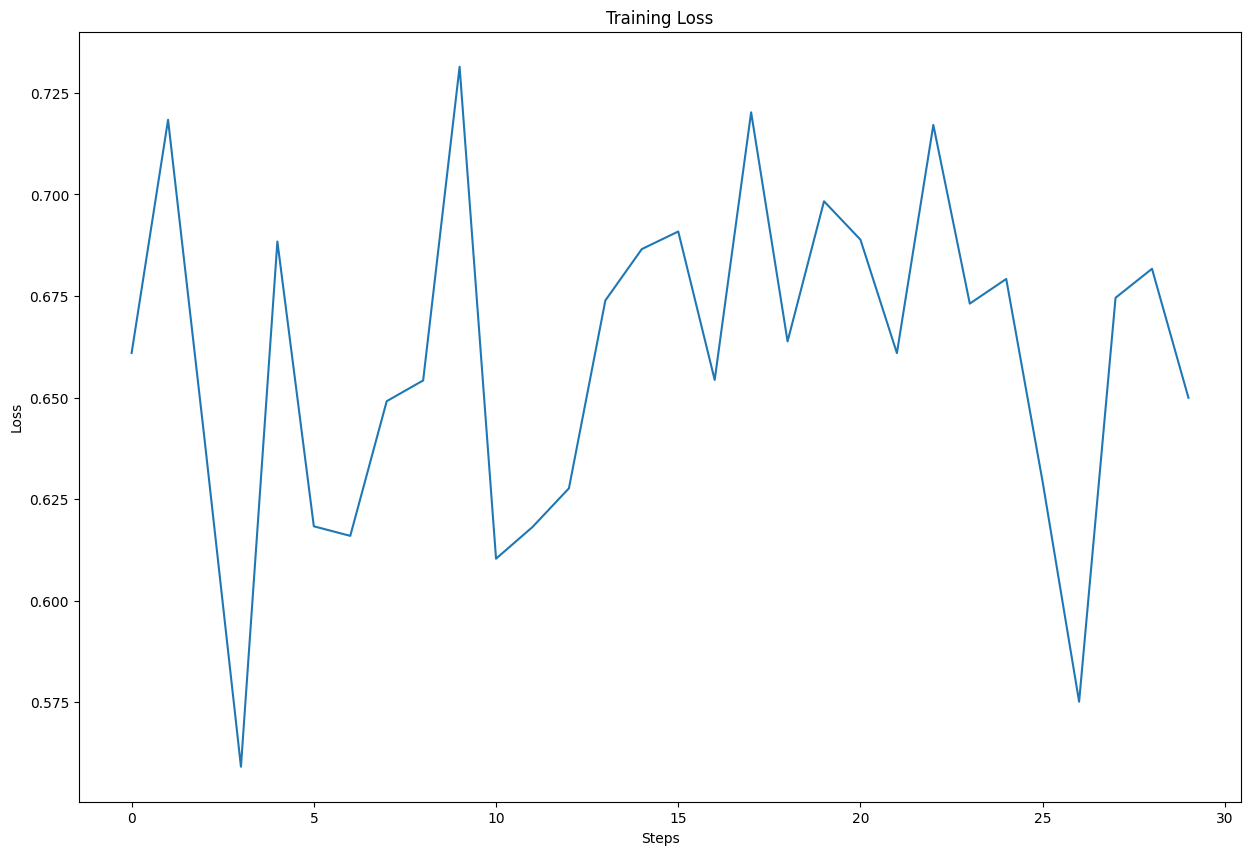

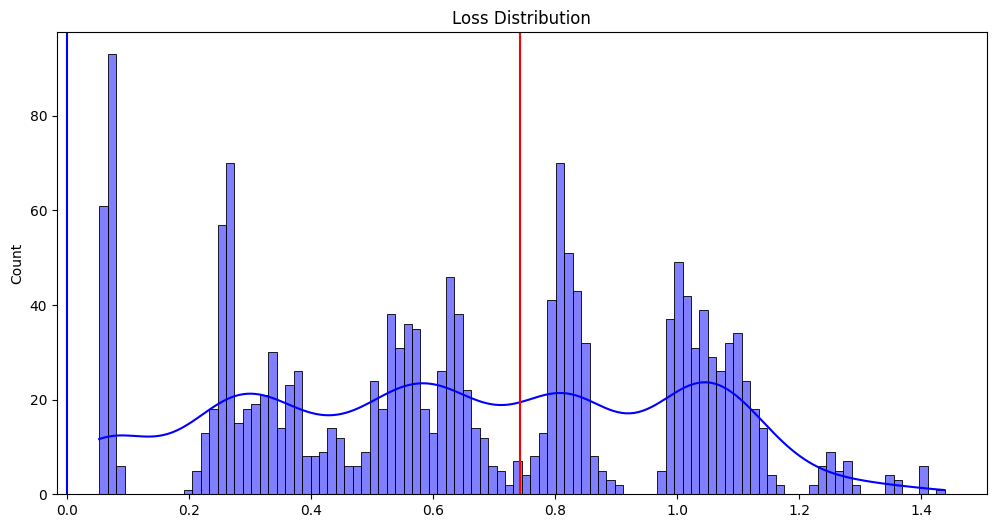

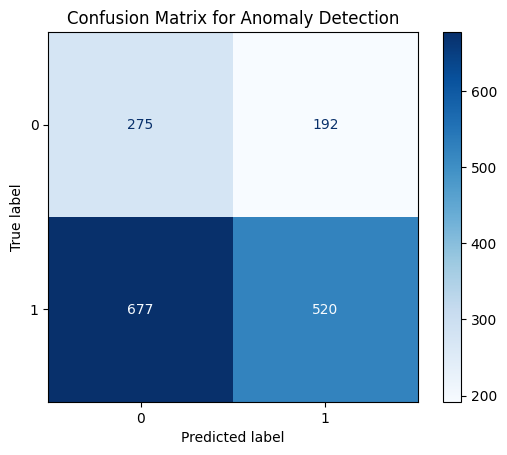

In [9]:

plt.figure(figsize=(12, 6))
plt.title('Reconstruction Error Distribution')
sns.histplot(recon_errors, bins=100, kde=True, color='blue')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()


with torch.no_grad():
    outputs = autoencoder(imgs)

plt.figure(figsize=(12, 6))
plt.title('Reconstructed Images')
plt.imshow(np.transpose(torchvision.utils.make_grid(outputs.cpu().detach(), padding=2, normalize=True), (1, 2, 0)))
plt.axis('off')
plt.show()


plt.figure(figsize=(15, 10))
plt.title('Training Loss')
plt.plot(train_losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()


plt.figure(figsize=(12, 6))
plt.title('Loss Distribution')
sns.histplot(recon_errors, bins=100, kde=True, color='blue')
plt.axvline(initial_threshold, color='r')
plt.axvline(0.0, color='b')
plt.show()

conf_matrix = confusion_matrix(true_labels_list, pred_labels_list)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Anomaly Detection')
plt.show()


### FOR 1000 EPOCHS

In [12]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve


data_dir = '/content/drive/MyDrive/ACV/mvtec_anomaly_detection'


class MyDataset(Dataset):
    def __init__(self, base_dir, data_type, transform=None):
        self.base_dir = base_dir
        self.data_type = data_type
        self.transform = transform
        self.image_files = []
        self.targets = []
        self.normal_count = 0
        self.anomaly_count = 0

        for category in os.listdir(base_dir):
            category_path = os.path.join(base_dir, category)
            if os.path.isdir(category_path):
                type_path = os.path.join(category_path, data_type)
                if os.path.isdir(type_path):
                    for defect_class in os.listdir(type_path):
                        defect_class_path = os.path.join(type_path, defect_class)
                        if os.path.isdir(defect_class_path):
                            for img_file in os.listdir(defect_class_path):
                                img_file_path = os.path.join(defect_class_path, img_file)
                                if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
                                    self.image_files.append(img_file_path)
                                    if data_type == 'train' or defect_class.lower() == 'good':
                                        self.targets.append(0)  # Normal images
                                        self.normal_count += 1
                                    else:
                                        self.targets.append(1)  # Anomalous images
                                        self.anomaly_count += 1

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_path = self.image_files[index]
        img = Image.open(img_path).convert('RGB')
        label = self.targets[index]
        if self.transform:
            img = self.transform(img)
        return img, label

img_transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])


train_data = MyDataset(data_dir, 'train', transform=img_transform)
test_data = MyDataset(data_dir, 'test', transform=img_transform)

train_loader = DataLoader(train_data, shuffle=True, batch_size=64, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=64, drop_last=True)

print(f"Training images: {len(train_data)}")
print(f"  Normal in training set: {train_data.normal_count}")
print(f"Testing images: {len(test_data)}")
print(f"  Normal in test set: {test_data.normal_count}")
print(f"  Anomalous in test set: {test_data.anomaly_count}")

Training images: 3629
  Normal in training set: 3629
Testing images: 1725
  Normal in test set: 467
  Anomalous in test set: 1258


In [14]:

learning_rate = 1e-4
training_steps = 100 
batch_sz = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {'GPU' if torch.cuda.is_available() else 'CPU'}.")


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model and optimizer
autoencoder = AutoEncoder().to(device)
autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
print(f'> Model parameters: {sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)}')

Training on GPU.
> Model parameters: 38723


  0%|          | 0/100 [00:00<?, ?it/s]

Step: 0   Loss: 0.763


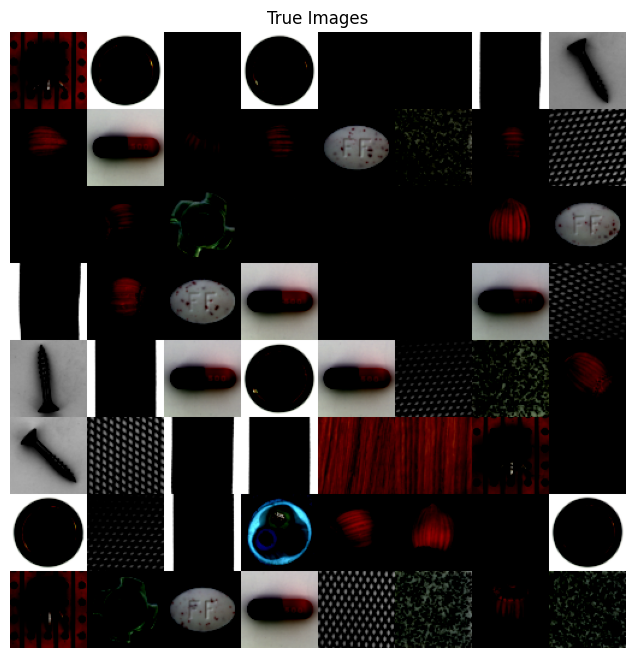

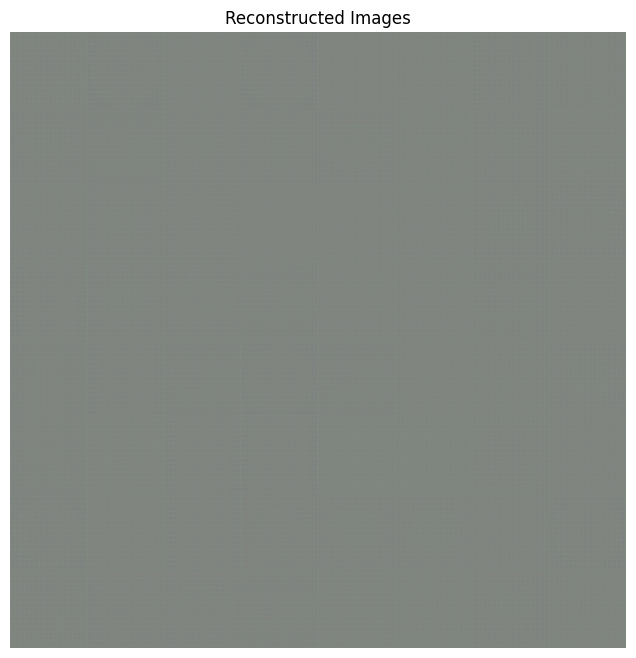

100%|██████████| 100/100 [16:24<00:00,  9.84s/it]


In [15]:

train_losses = []
for step in tqdm(range(training_steps)):
    x, _ = next(iter(train_loader))
    x = x.to(device)

    # Forward pass
    outputs = autoencoder(x)
    loss = nn.MSELoss()(outputs, x)

    # Backward pass
    autoencoder_optimizer.zero_grad()
    loss.backward()
    autoencoder_optimizer.step()

    train_losses.append(loss.item())

    if step % 100 == 0:
        print(f"Step: {step}   Loss: {loss.item():.3f}")

      
        reconstructions = torchvision.utils.make_grid(torch.clamp(outputs, 0, 1).detach(), padding=0, nrow=8)
        true_images = torchvision.utils.make_grid(torch.clamp(x, 0, 1).detach(), padding=0, nrow=8)

        plt.figure(figsize=(8, 8))
        plt.title('True Images')
        plt.imshow(np.transpose(true_images.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')

        plt.figure(figsize=(8, 8))
        plt.title('Reconstructed Images')
        plt.imshow(np.transpose(reconstructions.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')

        plt.show()

In [16]:

def dynamic_threshold(loss_vals):
    mean_loss = np.mean(loss_vals)
    std_loss = np.std(loss_vals)
    return mean_loss + 2 * std_loss  


initial_threshold = dynamic_threshold(train_losses)
print(f"Initial anomaly detection threshold: {initial_threshold}")


def reconstruction_errors(autoencoder, data_loader):
    autoencoder.eval()
    errors = []
    true_labels = []
    with torch.no_grad():
        for imgs, labels in tqdm(data_loader, desc="Evaluating"):
            imgs = imgs.to(device)
            outputs = autoencoder(imgs)
            loss = torch.mean((outputs - imgs) ** 2, dim=[1, 2, 3])
            errors.extend(loss.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(errors), np.array(true_labels)


recon_errors, true_lbls = reconstruction_errors(autoencoder, test_loader)


assert recon_errors.shape == true_lbls.shape, "Shape mismatch between errors and true labels."


anomalies_detected = recon_errors > initial_threshold
print(f"Detected anomalies: {np.sum(anomalies_detected)}")

true_labels_list = []
pred_labels_list = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Anomaly Detection"):
        imgs = imgs.to(device)
        outputs = autoencoder(imgs)
        recon_error = torch.mean((outputs - imgs) ** 2, dim=[1, 2, 3]).cpu().numpy()
        true_labels_list.extend(labels.cpu().numpy())
        pred_labels_list.extend([1 if e > initial_threshold else 0 for e in recon_error])

print(f"Anomalies detected in the test set: {np.sum(anomalies_detected)}")



Initial anomaly detection threshold: 0.8382874028175237


Evaluating: 100%|██████████| 26/26 [01:10<00:00,  2.69s/it]


Detected anomalies: 45


Anomaly Detection: 100%|██████████| 26/26 [01:07<00:00,  2.58s/it]

Anomalies detected in the test set: 45


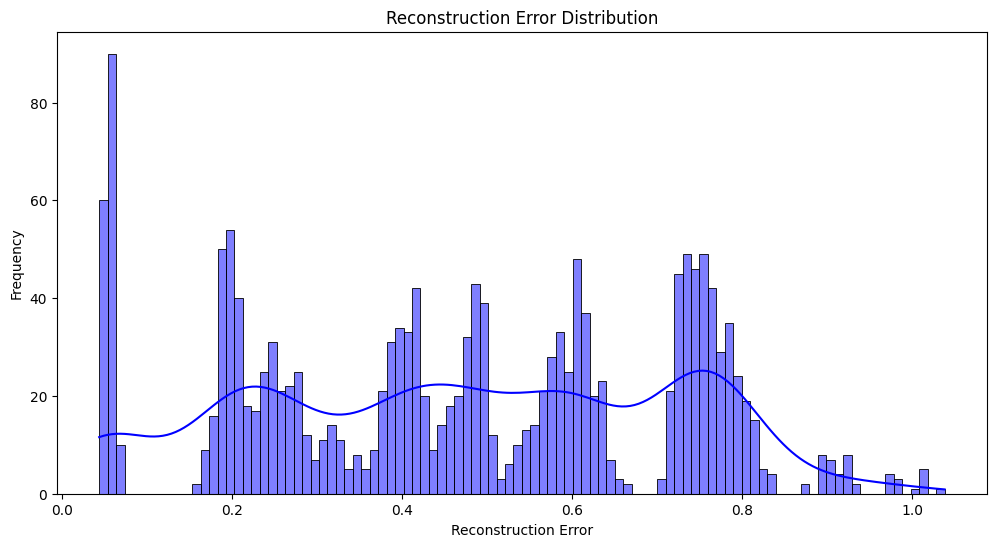

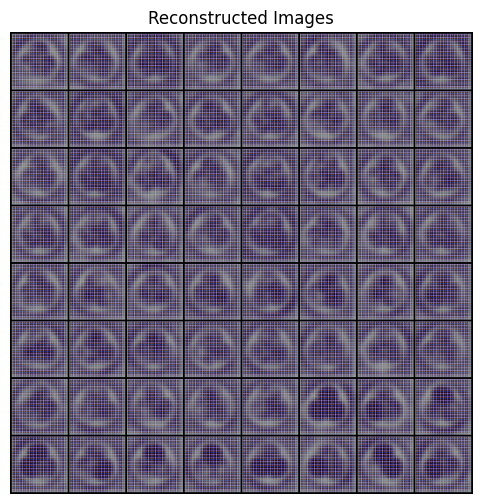

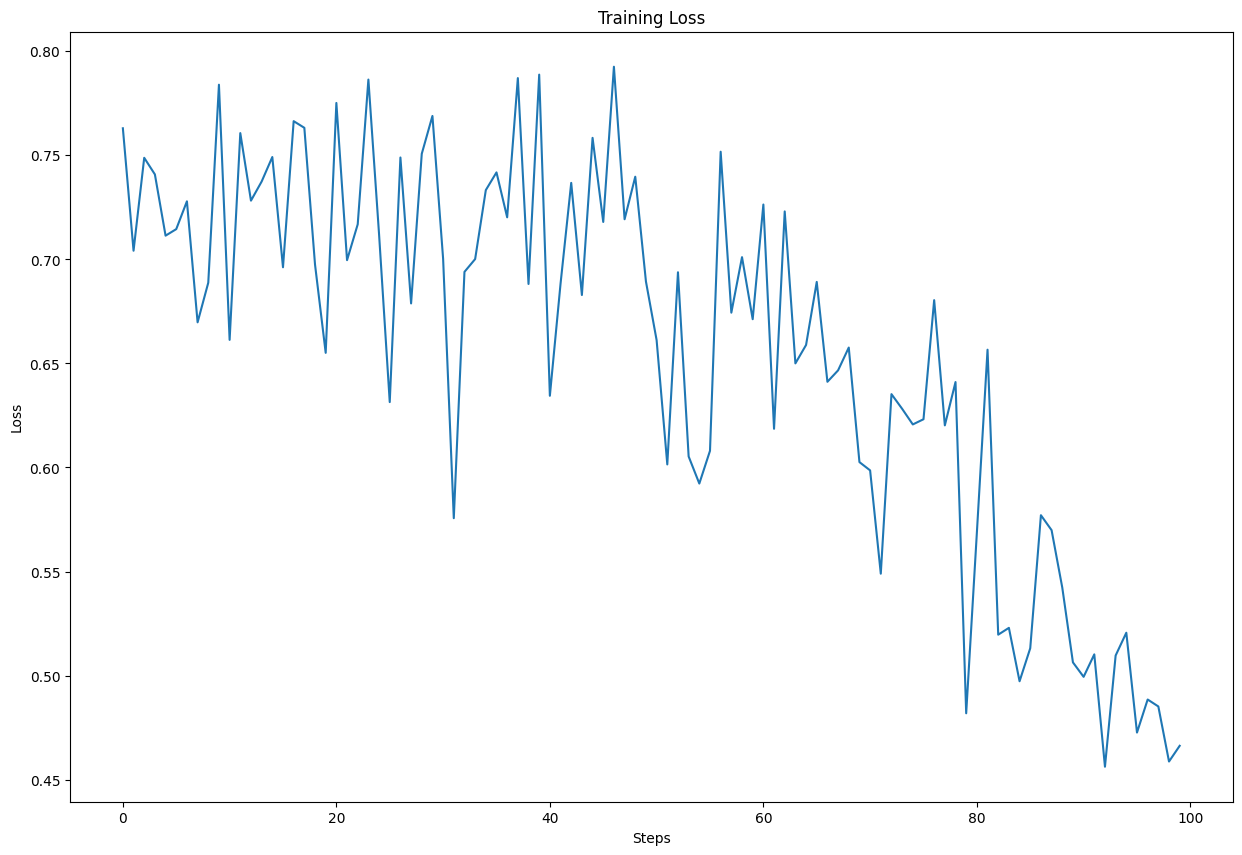

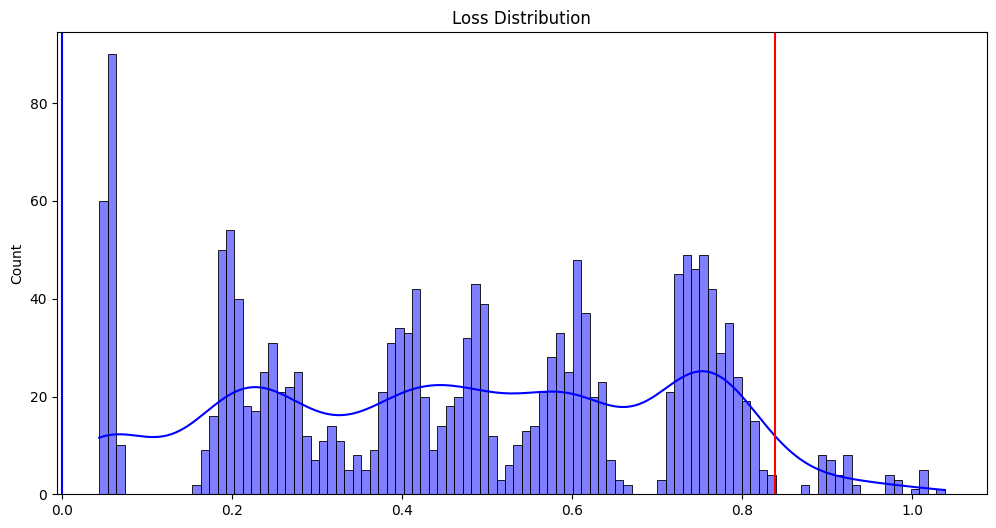

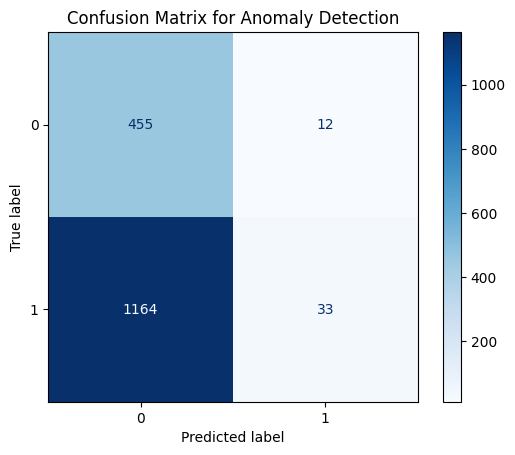

In [17]:

plt.figure(figsize=(12, 6))
plt.title('Reconstruction Error Distribution')
sns.histplot(recon_errors, bins=100, kde=True, color='blue')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()


with torch.no_grad():
    outputs = autoencoder(imgs)

plt.figure(figsize=(12, 6))
plt.title('Reconstructed Images')
plt.imshow(np.transpose(torchvision.utils.make_grid(outputs.cpu().detach(), padding=2, normalize=True), (1, 2, 0)))
plt.axis('off')
plt.show()


plt.figure(figsize=(15, 10))
plt.title('Training Loss')
plt.plot(train_losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Loss Distribution')
sns.histplot(recon_errors, bins=100, kde=True, color='blue')
plt.axvline(initial_threshold, color='r')
plt.axvline(0.0, color='b')
plt.show()

conf_matrix = confusion_matrix(true_labels_list, pred_labels_list)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Anomaly Detection')
plt.show()
